In [30]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import requests
import copy
import torch
import base64
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
import base64
import io
from jupyter_bbox_widget import BBoxWidget

### Pretrained model test

In [ ]:
#Load model:
model_id = "microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/opt/conda/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [7]:
def run_example(image, task_prompt, text_input=''):
    prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors='pt').to('cuda', torch.float16)

    generated_ids = model.generate(
        input_ids=inputs['input_ids'].cuda(),
        pixel_values=inputs['pixel_values'].cuda(),
        max_new_tokens=1024,
        do_sample=False, # deterministic.
        num_beams=3, # top 3 most likely tokens at each step.
        early_stopping=False, # Ensures beam search continues until all beams reach the maximum length or an end-of-sequence token is generated
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [ ]:
# https://image.dongascience.com/Photo/2017/03/14906619047665.jpg

In [15]:
import requests
from PIL import Image as PILImage

image = PILImage.open(requests.get("https://image.dongascience.com/Photo/2017/03/14906619047665.jpg", stream=True).raw).convert("RGB")

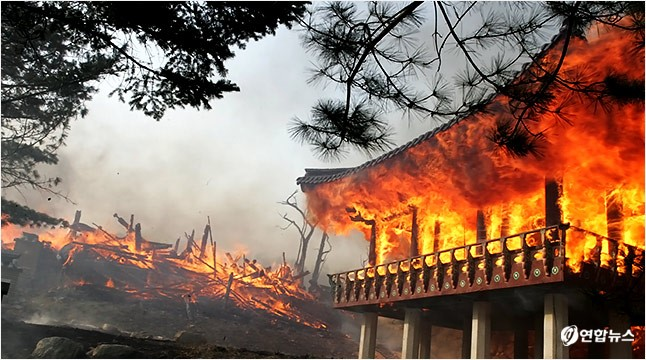

In [16]:
image

In [13]:
def draw_bbox(image, data):

    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    ax.axis('off')
    plt.show()



def draw_ocr_bboxes(image, prediction):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        if label.startswith('</s>'):
          label = label[4:]

        color = (238, 130, 238, 128)
        new_box = np.array(box).tolist()
        draw.polygon(new_box, width=3, outline=color)

        draw.text((new_box[0], new_box[1]+30),
                    "{}".format(label),
                    align="right",
                    fill='aqua')
    display(image)




def draw_polygons(image, prediction):

    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    color = (238, 130, 238, 128)  # violet, semi-transparent
    outline_color = (*color[:3], 255)  # Full opacity for outline

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        for polygon in polygons:
            polygon = np.array(polygon).flatten().tolist()
            if len(polygon) < 6:  # Less than 3 points
                continue

            draw.polygon(polygon, outline=outline_color, fill=color)
            draw.text((polygon[0] + 8, polygon[1] + 2), label, fill=outline_color)

    return Image.alpha_composite(image.convert('RGBA'), overlay)

### 일반 캡션 생성

In [17]:
print (run_example(image, task_prompt='<CAPTION>'))

{'<CAPTION>': 'a house is engulfed by flames in the middle of a forest'}


In [18]:
print (run_example(image, task_prompt='<DETAILED_CAPTION>'))

{'<DETAILED_CAPTION>': 'The image shows a house engulfed in flames in the middle of a forest, with smoke billowing up into the sky. The house is surrounded by trees and rocks, and there is a watermark in the bottom right corner of the image. This scene is a reminder of the devastating effects of the Korean fire, which has killed over 100 people.'}


In [19]:
print (run_example(image, task_prompt='<MORE_DETAILED_CAPTION>'))

{'<MORE_DETAILED_CAPTION>': 'The image shows a house on fire. The house is on the right side of the image and is engulfed in flames. The flames are bright orange and yellow, and the roof is completely destroyed. The roof appears to be in a state of disrepair, with charred walls and debris scattered around the area. The sky is dark and cloudy, and there are trees in the background. The image is taken from a low angle, looking up at the house and the fire.'}


### 지정한 영역에 대해 설명

In [45]:
# def encode_image(filepath):
#     with open(filepath, 'rb') as f:
#         image_bytes = f.read()
#     encoded = str(base64.b64encode(image_bytes), 'utf-8')
#     return "data:image/jpg;base64,"+encoded


def encode_image_to_base64(pil_image_obj, image_format="JPEG"):
    buffered = io.BytesIO()
    pil_image_obj.save(buffered, format=image_format)
    image_bytes = buffered.getvalue()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return f"data:image/{image_format.lower()};base64," + encoded

def convert_bbox_to_florence2(widget, image_path):
    """Convert widget bbox to Florence-2 format."""
    box = widget.bboxes[0]
    box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

    w, h = Image.open(image_path).size
    box = (box / [w, h, w, h] * 1000).astype(int)

    return ''.join(f'<loc_{coord}>' for coord in box)

def pixel_bbox_to_florence(box_px, image):
    """box_px = [x1, y1, x2, y2] in pixel coords"""
    w, h = image.size # PIL Image
    box = (np.array(box_px) / np.array([w, h, w, h]) * 1000).astype(int)
    return ''.join(f'<loc_{c}>' for c in box)          # "<loc_123><loc_456>…"


def convert_to_od_format(data):

    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [29]:
type(image)

PIL.Image.Image

In [49]:
w,h = image.size
w,h

(646, 360)

In [50]:
box_px  = [294, 0, 645, 359]

In [ ]:
# 1000배 비율 곱
box = (np.array(box_px) / np.array([w, h, w, h]) * 1000).astype(int)

In [57]:
w, h

(646, 360)

In [55]:
box

array([455,   0, 998, 997])

In [58]:
box_px[0]/w * 1000

455.1083591331269

In [51]:
box_str = pixel_bbox_to_florence(box_px, image)

In [ ]:
# 1000개의 블록 좌표로 전환한다고 생각
box_str

'<loc_455><loc_0><loc_998><loc_997>'

In [53]:
print(run_example(image, '<REGION_TO_DESCRIPTION>', text_input=box_str))

{'<REGION_TO_DESCRIPTION>': 'Korean temple fire<loc_455><loc_0><loc_998><loc_997>'}


###  Bounding Boxes and Text for Objects

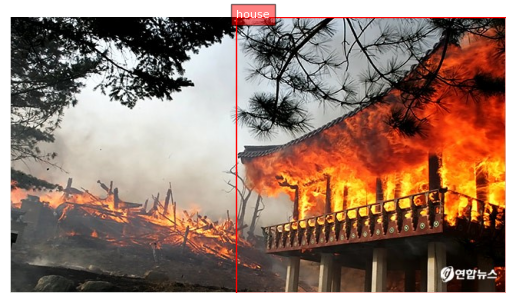

{'<OD>': {'bboxes': [[294.2530212402344, 0.5400000214576721, 645.031005859375, 359.46002197265625]], 'labels': ['house']}}


In [34]:
results = run_example(image, task_prompt='<OD>')
draw_bbox(image, results['<OD>'])
print(results)

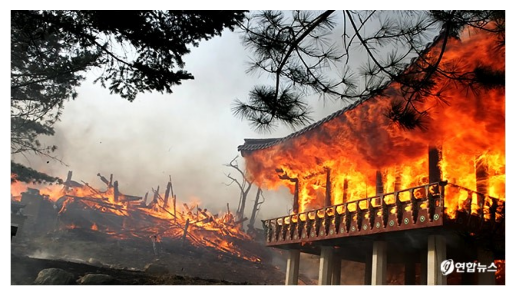

{'<DENSE_REGION_CAPTION>': {'bboxes': [], 'labels': []}}


In [35]:
results = run_example(image, task_prompt = '<DENSE_REGION_CAPTION>')
draw_bbox(image, results['<DENSE_REGION_CAPTION>'])
print(results)

### Text Grounded Object Detection

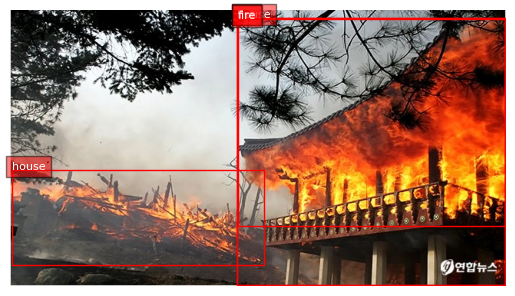

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[295.5450134277344, 9.90000057220459, 644.385009765625, 358.3800048828125], [1.6150000095367432, 208.260009765625, 330.42901611328125, 331.7400207519531], [295.5450134277344, 10.260000228881836, 644.385009765625, 358.02001953125], [296.1910095214844, 11.700000762939453, 644.385009765625, 281.70001220703125]], 'labels': ['house', 'house', 'fire', 'fire']}}


In [ ]:
results = run_example(image,task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>', text_input="house. fire. ")
draw_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

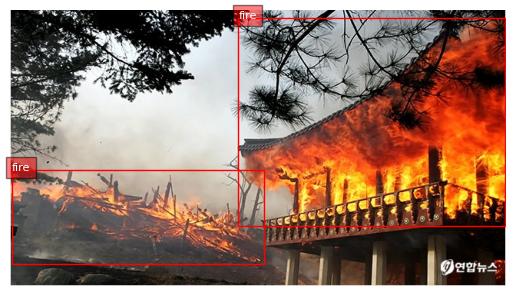

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[296.8370056152344, 10.980000495910645, 644.385009765625, 280.9800109863281], [1.6150000095367432, 208.98001098632812, 330.42901611328125, 330.6600036621094]], 'labels': ['fire', 'fire']}}


In [ ]:
# Text Grounded Object Detection
results = run_example(image,task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>', text_input="fire. ")
draw_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

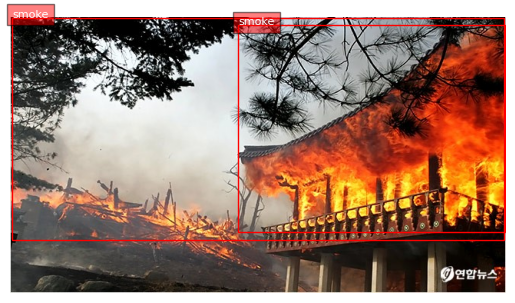

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[2.261000156402588, 1.2599999904632568, 643.093017578125, 290.70001220703125], [296.8370056152344, 10.620000839233398, 644.385009765625, 279.5400085449219]], 'labels': ['smoke', 'smoke']}}


In [ ]:
# Text Grounded Object Detection
results = run_example(image,task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>', text_input="smoke. ")
draw_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

### Text Grounded Segmentation

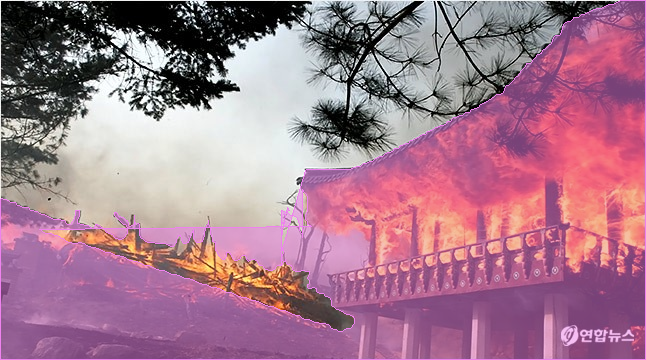

In [ ]:
# Text Grounded Segmentation
# 12.4s
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(image, task_prompt, text_input="fire")
output_image = copy.deepcopy(image)
draw_polygons(output_image, results[task_prompt])

### Optical Character Recognition (OCR)

In [60]:
task_prompt = '<OCR>'
run_example(image,task_prompt)

{'<OCR>': '아리스타에세요\n'}

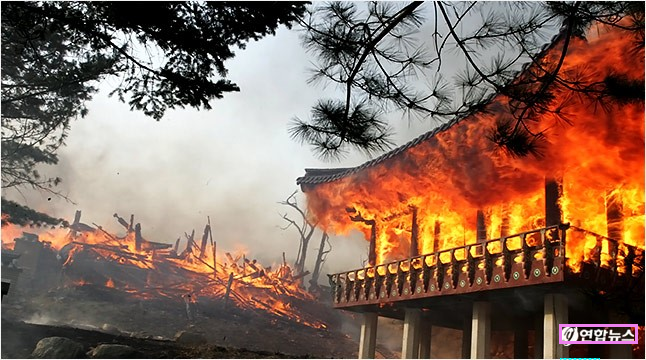

{'<OCR_WITH_REGION>': {'quad_boxes': [[559.759033203125, 324.9000244140625, 637.279052734375, 324.9000244140625, 637.279052734375, 343.9800109863281, 559.759033203125, 343.9800109863281]], 'labels': ['</s>아로리스타에세요']}}


In [61]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(image,task_prompt)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])
print(results)

### Finetuned Model

In [62]:
#Load model:
model_id = "microsoft/Florence-2-large-ft"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

###  Bounding Boxes and Text for Objects

In [67]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 



device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large-ft", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large-ft", trust_remote_code=True)

prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


AttributeError: 'Florence2LanguageForConditionalGeneration' object has no attribute 'generate'

### Optical Character Recognition (OCR)

In [63]:
task_prompt = '<OCR>'
run_example(image,task_prompt)

AttributeError: 'Florence2LanguageForConditionalGeneration' object has no attribute 'generate'